In [9]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow as tf
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import datetime
import pandas as pd

In [21]:
# Directory Management for Raw Image datasets
data_dir_raw_image = 'datasets/image'
data_dir_raw_image = pathlib.Path(data_dir_raw_image)
raw_durian_images_dict = {
    'ripe' : list(data_dir_raw_image.glob('ripe/*')),
    'unripe' : list(data_dir_raw_image.glob('unripe/*')),
} 
raw_durian_labels_dict = {
    'ripe' : 0,
    'unripe' : 1
}
print(f'jumlah durian matang : {len(raw_durian_images_dict["ripe"])}')
print(f'jumlah durian mentah : {len(raw_durian_images_dict["unripe"])}')

jumlah durian matang : 50
jumlah durian mentah : 50


In [22]:
def load_data(data_dir):
    data_gas = []
    label_gas = []
    for label, class_name in enumerate(['ripe', 'unripe']):
        class_dir = os.path.join(data_dir, class_name)
        for filename in os.listdir(class_dir):
            if filename.endswith('.csv'):
                file_path = os.path.join(class_dir, filename)
                csv_data = pd.read_csv(file_path).values.flatten()
                data_gas.append(csv_data)
                label_gas.append(label)
    return np.array(data_gas), np.array(label_gas)

In [23]:
data_dir = 'datasets/aroma'
data_gas, label_gas = load_data(data_dir)
# Normalize the data
scaler = MinMaxScaler()
data = scaler.fit_transform(data_gas)
# Menyimpan scaler ke file
scaler_file = "scaler.pkl"
joblib.dump(scaler, scaler_file)
max_len = max(map(len, data))
data = np.array([np.pad(d, (0, max_len - len(d)), 'constant') for d in data])
len(data)
len(label_gas)

100

In [24]:
X_image, y_image = [], []
for durian_ripeness, images in raw_durian_images_dict.items():
    for index, image in enumerate(images):
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(200,200))
        X_image.append(resized_img)
        y_image.append(raw_durian_labels_dict[durian_ripeness])
X_image = np.array(X_image)
y_image = np.array(y_image)
len(y_image)

100

In [6]:
from sklearn.model_selection import train_test_split
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X_raw, y_raw, train_size=0.7)
X_train_gas, X_test_gas, y_train_gas, y_test_gas = train_test_split(X_gas, y_gas, train_size=0.7)

# Scaling Raw dataset
X_train_scaled_raw = X_train_raw /255
X_test_scaled_raw = X_test_raw /255
# Scaling Gas dataset
X_train_scaled_gas = X_train_gas /255
X_test_scaled_gas = X_test_gas /255

In [7]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, concatenate
from tensorflow.keras.models import Model

input_shape_raw = (200, 200, 3)  
input_shape_gas = (200, 200, 3)  

# Define two separate input layers
input_raw = Input(shape=input_shape_raw)
input_gas = Input(shape=input_shape_gas)

In [8]:
convDim = 3  # Define the convolution dimension

In [9]:
# Convolution layer for Raw dataset
conv1_raw = Conv2D(16, (convDim, convDim), activation='relu', input_shape=input_shape_raw)(input_raw)
pool1_raw = MaxPooling2D(2, 2)(conv1_raw)

conv2_raw = Conv2D(32, (convDim, convDim), activation='relu')(pool1_raw)
pool2_raw = MaxPooling2D(2, 2)(conv2_raw)

flat_raw = Flatten()(pool2_raw)

In [10]:
# Convolution layer for Gas dataset
conv1_gas = Conv2D(16, (convDim, convDim), activation='relu', input_shape=input_shape_gas)(input_gas)
pool1_gas = MaxPooling2D(2, 2)(conv1_gas)

conv2_gas = Conv2D(32, (convDim, convDim), activation='relu')(pool1_gas)
pool2_gas = MaxPooling2D(2, 2)(conv2_gas)

flat_gas = Flatten()(pool2_gas)

In [11]:
# Concatenate the flattened outputs
merged = concatenate([flat_raw, flat_gas])

In [12]:
# Fully Connected Layer
fc2 = Dense(128, activation='relu')(merged)
fc3 = Dense(64, activation='relu')(fc2)
output = Dense(1, activation='sigmoid')(fc3)

# Create the model
model = Model(inputs=[input_raw, input_gas], outputs=output)

In [14]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    # Check the loss
    if(logs.get('accuracy') == 1.0):

      # Stop if threshold is met
      print("\nAccuracy is reached than 1.0 so cancelling training!")
      self.model.stop_training = True

# Instantiate class
callbacks = myCallback()
# callbacks=callbacks

In [15]:
# Train the model
model_fit = model.fit(
 ( X_train_scaled_raw, X_train_scaled_gas), 
 y_train_raw, 
 epochs=50,
 validation_data=(
        ( X_test_scaled_raw, X_test_scaled_gas), 
        ( y_test_raw, y_test_gas)
    ),
#  callbacks=callbacks
 )

Epoch 1/50
3/3 [==============================] - 10s 2s/step - loss: 1.0262 - accuracy: 0.5143 - val_loss: 4.1958 - val_accuracy: 0.4667
Epoch 2/50
3/3 [==============================] - 5s 1s/step - loss: 2.1340 - accuracy: 0.5429 - val_loss: 1.3027 - val_accuracy: 0.5333
Epoch 3/50
3/3 [==============================] - 4s 1s/step - loss: 1.2865 - accuracy: 0.4857 - val_loss: 0.6958 - val_accuracy: 0.5000
Epoch 4/50
3/3 [==============================] - 4s 1s/step - loss: 0.6761 - accuracy: 0.4857 - val_loss: 0.9042 - val_accuracy: 0.4667
Epoch 5/50
3/3 [==============================] - 4s 1s/step - loss: 0.6395 - accuracy: 0.5286 - val_loss: 0.7359 - val_accuracy: 0.8000
Epoch 6/50
3/3 [==============================] - 4s 1s/step - loss: 0.5369 - accuracy: 0.8571 - val_loss: 0.5393 - val_accuracy: 0.7667
Epoch 7/50
3/3 [==============================] - 4s 1s/step - loss: 0.4272 - accuracy: 0.8857 - val_loss: 0.3628 - val_accuracy: 0.8667
Epoch 8/50
3/3 [========================

In [16]:
loss, accuracy = model.evaluate([X_test_scaled_raw, X_test_scaled_gas], [y_test_raw, y_test_gas])
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

1/1 [==============================] - 0s 376ms/step - loss: 0.0135 - accuracy: 1.0000
Test Loss: 0.01345971692353487
Test Accuracy: 1.0


In [17]:
predictions = model.predict([X_test_scaled_raw, X_test_scaled_gas])
predictions = np.round(predictions,2)
predictions

1/1 [==============================] - 1s 624ms/step


array([[1.  ],
       [1.  ],
       [1.  ],
       [1.  ],
       [0.  ],
       [0.97],
       [0.  ],
       [0.  ],
       [0.  ],
       [1.  ],
       [0.96],
       [0.  ],
       [1.  ],
       [0.  ],
       [1.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [1.  ],
       [0.9 ],
       [1.  ],
       [1.  ],
       [0.  ],
       [0.79],
       [1.  ],
       [1.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ]], dtype=float32)

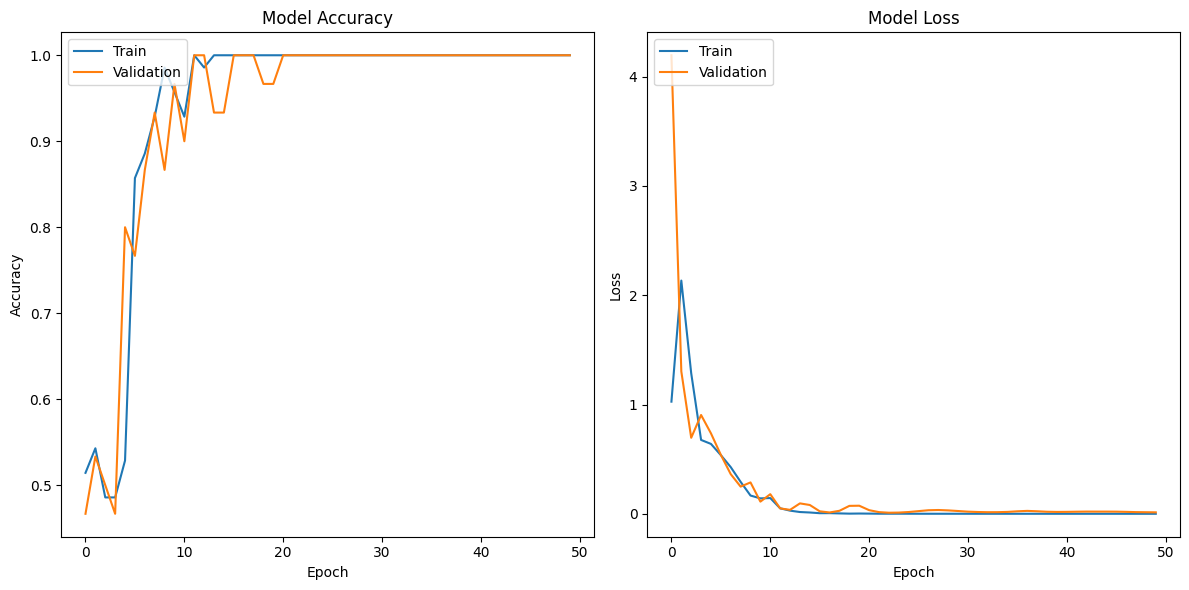

In [18]:
# Plot training and validation history
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(model_fit.history['accuracy'])
plt.plot(model_fit.history['val_accuracy'])  # Add validation accuracy
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(model_fit.history['loss'])
plt.plot(model_fit.history['val_loss'])  # Add validation loss
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
# Get current date and time
now = datetime.datetime.now()

# Format the date-time string as 'MMDDYYYY-HHMM'
date_time_str = now.strftime("%d%m%Y-%H%M")

# Save the plot with the specified name format
plt.savefig(f"{date_time_str}.png")

plt.show()

1/1 [==============================] - 0s 291ms/step


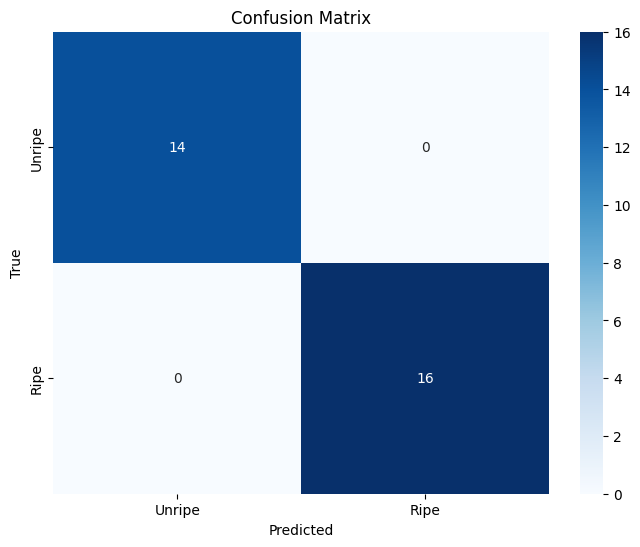

In [21]:
from sklearn.metrics import confusion_matrix

# Generate predictions on the test set
y_pred = model.predict([X_test_scaled_raw, X_test_scaled_gas])
y_pred_classes = (y_pred > 0.5).astype(int)  # Assuming it's a binary classification problem

# Assuming y_test contains the true labels for the test set
# Generate the confusion matrix
conf_mat = confusion_matrix(y_test_raw, y_pred_classes)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Unripe', 'Ripe'], yticklabels=['Unripe', 'Ripe'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()